The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


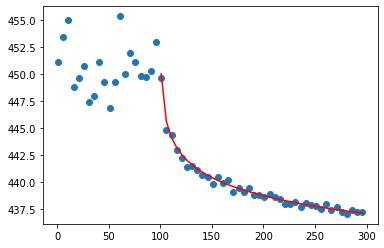

In [260]:
# Simulate different datasets with different error assumptions
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import seaborn as sns
import sys
sys.path.append("../")
import matplotlib.pyplot as plt
from curve_models import NLLS, NLLS_w, NLLS_rse, power_law, CurveModel
import statsmodels.api as sm

def quadratic(x, a, b):
    return a*x**2 + b

def linearized_power_law(x, a, b):
    return np.exp(b + a*np.log(x))

def exponential_law(x, a, b):
    return a*(b**(1/x))

def simulate_data(a, b, n_steps):
    x = []
    y = []
    x_samples = []
    y_samples = []   
    n_redundant = 1
    burn_in = 100
    for i in range(1, n_steps, 5):
        if i > burn_in:
            x.append(i)
            val = power_law(i-burn_in, a, b)
            y.append(val)
        for j in range(n_redundant):
            x_samples.append(i)
            if i < burn_in:
                noise = np.random.normal(450, 3, 1)[0]
                val = noise
            else:
                noise = np.random.normal(0, 15, 1)[0]/(i**.75)
                val = val+noise
            y_samples.append(val) 
    return x, y, x_samples, y_samples
n_steps = 300
a, b = .0055, 450
x, y, x_samples, y_samples = simulate_data(a, b, n_steps)
plt.scatter(x_samples, y_samples)
plt.plot(x, y, c='r')

In [ ]:
nlls = NLLS(power_law)
nlls.fit(x_samples, y_samples)
nlls_w = NLLS_w(power_law)
nlls_w.fit(x_samples, y_samples)
n_eval_steps = 2000
nlls_y = [nlls.f(x, **nlls.p) for x in range(1, n_eval_steps, 5)]
nlls_w_y = [nlls_w.f(x, **nlls_w.p) for x in range(1, n_eval_steps, 5)]


log_x_samples = [np.log(i) for i in x_samples]
log_y_samples = [np.log(i) for i in y_samples]
log_x_samples = sm.add_constant(log_x_samples)
result = sm.OLS(log_y_samples, log_x_samples, cov_type='HC0').fit()
result = result.get_robustcov_results('HC3')
params = result.params
print(params)
nls_rse_y = [linearized_power_law(x, params[1], params[0]) for x in range(1, n_eval_steps, 5)]

true_y = [power_law(x-50, a, b) for x in range(51, n_eval_steps+51, 5)]
x_eval = list(range(1, n_eval_steps, 5))
true_x_eval = list(range(51, n_eval_steps+51, 5))



plt.plot(x_eval, nlls_y, c='blue', alpha=.5, label='nls')
plt.plot(x_eval, nlls_w_y, c='g', alpha=.5, label='nls_w')
plt.plot(x_eval, nls_rse_y, c='cyan', alpha=1, label='nls_rse')
plt.plot(true_x_eval, true_y, c='r', alpha=.5, label='true')
plt.legend()
# fit NNLS
# fit NNLS_w
# fit NNLS_rse

In [ ]:
p_vals = []
thresholds = list(range(1, n_steps, 5))
for t in thresholds:
    x_s_copy = x_samples.copy()
    y_s_copy = y_samples.copy()
    x_s_copy = np.array([x for x in x_s_copy if x > t])
    y_s_copy = np.array(y_s_copy[-len(x_s_copy):])
    if len(x_s_copy) > 30:
        print(len(x_s_copy))
        nlls_rse = NLLS_rse(linearized_power_law)
        sampled_idxs = np.random.choice(list(range(len(x_s_copy))), 100).astype(int)
        nlls_rse.fit(x_s_copy[sampled_idxs], y_s_copy[sampled_idxs])
        p_dict = nlls_rse.p
        p_dict['a_cov'] = nlls_rse.pcov[0]
        p_dict['b_cov'] = nlls_rse.pcov[1]
        p_dict['rsq'] = nlls_rse.rsq
        p_dict['rsq_adj'] = nlls_rse.rsq_adj
        p_dict['ll'] = nlls_rse.ll
        p_dict['aic'] = nlls_rse.aic
        p_dict['bic'] = nlls_rse.bic
        p_dict['f_pval'] = nlls_rse.f_pval
        p_dict['f_test'] = nlls_rse.f_test
        p_dict['t'] = t
        p_vals.append(p_dict)
p_vals = pd.DataFrame(p_vals)

In [ ]:
sns.lineplot(x='t', y='b_cov', data=p_vals)

In [202]:
ss = np.loadtxt('../ss')
mses = np.loadtxt('../mses')
test_mses = np.loadtxt('../test_mses')


In [215]:
n_eval_steps = max(ss)
n_eval_steps = 1140000
x_samples = list(range(1, int(n_eval_steps), 5000))
nlls = NLLS(power_law)
nlls.fit(ss, mses)
nlls_y = [nlls.f(x, **nlls.p) for x in x_samples]

nlls_w = NLLS_w(power_law)
nlls_w.fit(ss[:], mses[:])
nlls_w_y = [nlls_w.f(x, **nlls_w.p) for x in x_samples]

nlls_rse = NLLS_rse(linearized_power_law, name='NLS_rse')
nlls_rse.fit(ss[:], mses[:])
nlls_rse_y = [nlls_rse.f(x, **nlls_rse.p) for x in x_samples]

nls_el = NLLS_w(exponential_law)
nls_el.fit(ss, mses)
nls_el_y = [nls_el.f(x, **nls_el.p) for x in x_samples]

[[2.66923913e-12 1.04449423e-05]
 [1.04449423e-05 4.10964211e+01]]


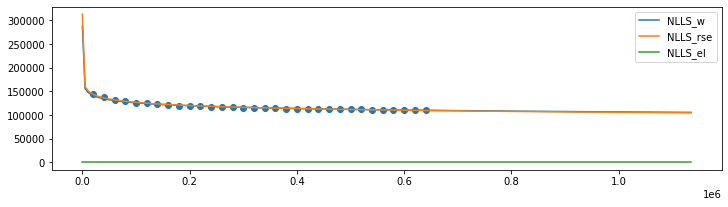

In [217]:
fig= plt.figure(figsize=(12,3))
plt.scatter(ss, mses)
#plt.scatter(ss, test_mses)
plt.plot(x_samples, nlls_w_y, label="NLLS_w")
plt.plot(x_samples, nlls_rse_y, label="NLLS_rse")
plt.plot(x_samples, nls_el_y, label="NLLS_el")
plt.legend()

In [212]:
nls_el = NLLS_w(exponential_law)
nls_el.fit(ss, mses)


/home/t-sdivya/.conda/envs/dm/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


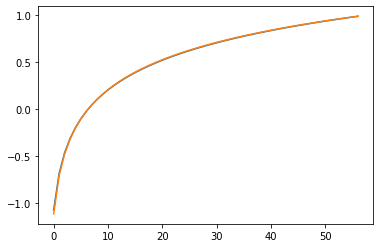

In [60]:
n_init = 147391
n_available = 1179131
def pred_pct(n_init, n_acquired, n_available, cm):
    pred_progress = cm.f(n_init, **cm.p) - cm.f(n_acquired, **cm.p) 
    pred_total = cm.f(n_init, **cm.p) - cm.f(n_available, **cm.p)
    return pred_progress/pred_total
plt.plot([pred_pct(n_init, n_acq, n_available, nlls_rse) for n_acq in ss])
plt.plot([pred_pct(n_init, n_acq, n_available, nlls_w) for n_acq in ss])

In [63]:
nlls_w.f(n_init, **nlls_w.p), nlls_w.f(n_available, **nlls_w.p)

(122238.71864332701, 104851.7802689183)

In [ ]:
plt.plot(np.log(ss), np.log(mses))

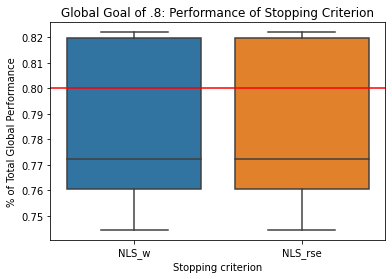

In [261]:
goal_pct = ".8"
goal_pct_float = float(goal_pct)
expmt = 'ml-20m-tiny_5_False_0.1_0.4_uniform_1000_250_0_30_1_20000_0.5_0.5_0_0.8'
data = pd.read_csv('../results/forecasting/' + expmt + '/results_df')
ax = sns.boxplot(x='curve_model', y='micro_pct', data=data[data['pred_pct'] > .8])
plt.xlabel("Stopping criterion")
plt.ylabel("% of Total Global Performance")
plt.title("Global Goal of " + goal_pct + ": Performance of Stopping Criterion")
ax.axhline(y=goal_pct_float, c='r')

In [262]:
nlsw_pred = data[data['curve_model'] == 'NLS_w']['micro_pct'] - float(goal_pct)
nlsrse_pred = data[data['curve_model'] == 'NLS_rse']['micro_pct'] - float(goal_pct)

In [263]:
from scipy.stats import ttest_rel
print(ttest_rel(nlsw_pred, nlsrse_pred))
np.mean(nlsw_pred), np.mean(nlsrse_pred)

Ttest_relResult(statistic=nan, pvalue=nan)


(-0.27915671221063443, -0.27915671221063443)

(0.2, 1.0)

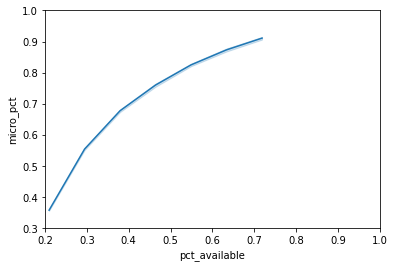

In [264]:
expmt = 'ml-20m-uniform_5_False_0.1_0.4_uniform_100000_30_1_1000000_20000_0_0.5_0.5_0_0.8'
data = pd.read_csv('../results/forecasting/' + expmt + '/results_df')
sns.lineplot(x='pct_available', y='micro_pct', data=data)
plt.ylim(.3, 1)
plt.xlim(.2, 1)

(0.2, 1.0)

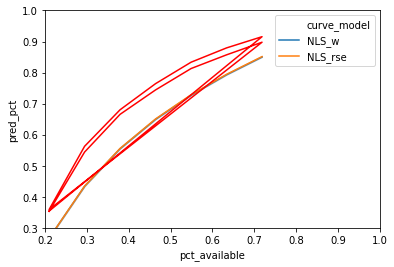

In [265]:
sns.lineplot(x='pct_available', y='pred_pct', data=data, hue='curve_model')
plt.plot(data['pct_available'][:29], data['micro_pct'][:29], c='r')
plt.ylim(.3, 1)
plt.xlim(.2, 1)

In [266]:
data['pct_available'], data['micro_pct']

(0     0.209808
 1     0.209808
 2     0.294616
 3     0.294616
 4     0.379424
         ...   
 65    0.549041
 66    0.633849
 67    0.633849
 68    0.718657
 69    0.718657
 Name: pct_available, Length: 70, dtype: float64,
 0     0.353265
 1     0.353265
 2     0.544114
 3     0.544114
 4     0.665578
         ...   
 65    0.828383
 66    0.877837
 67    0.877837
 68    0.915650
 69    0.915650
 Name: micro_pct, Length: 70, dtype: float64)

/home/t-sdivya/.conda/envs/dm/lib/python3.6/site-packages/seaborn/relational.py:818: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  line, = ax.plot([], [], **kws)
/home/t-sdivya/.conda/envs/dm/lib/python3.6/site-packages/seaborn/relational.py:829: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  line, = ax.plot(x, y, **kws)


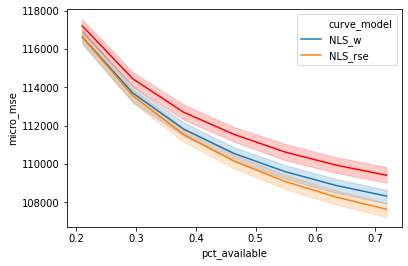

In [267]:
data.keys()
expmt = 'ml-20m-uniform_5_False_0.1_0.4_uniform_100000_30_1_1000000_20000_0_0.5_0.5_0_0.8'
data = pd.read_csv('../results/forecasting/' + expmt + '/results_df')
sns.lineplot(x='pct_available', y='pred_curr', data=data, hue='curve_model')
nlsw = data[data['curve_model'] == 'NLS_w']
sns.lineplot(x='pct_available', y='micro_mse', data=nlsw, c='r')

/home/t-sdivya/.conda/envs/dm/lib/python3.6/site-packages/seaborn/relational.py:818: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  line, = ax.plot([], [], **kws)
/home/t-sdivya/.conda/envs/dm/lib/python3.6/site-packages/seaborn/relational.py:829: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  line, = ax.plot(x, y, **kws)


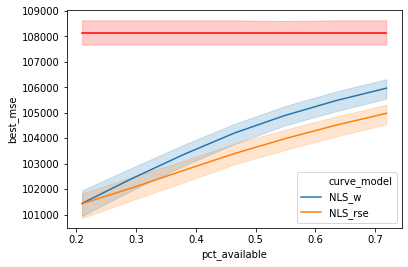

In [268]:
sns.lineplot(x='pct_available', y='pred_best', data=data, hue='curve_model')
nlsw = data[data['curve_model'] == 'NLS_w']
sns.lineplot(x='pct_available', y='best_mse', data=nlsw, c='r')

/home/t-sdivya/.conda/envs/dm/lib/python3.6/site-packages/seaborn/relational.py:818: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  line, = ax.plot([], [], **kws)
/home/t-sdivya/.conda/envs/dm/lib/python3.6/site-packages/seaborn/relational.py:829: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  line, = ax.plot(x, y, **kws)


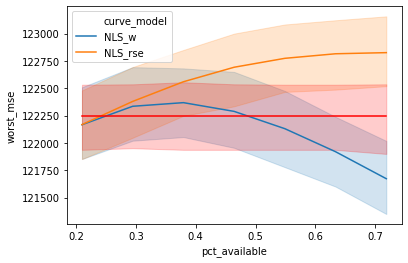

In [269]:
sns.lineplot(x='pct_available', y='pred_worst', data=data, hue='curve_model')
nlsw = data[data['curve_model'] == 'NLS_w']
sns.lineplot(x='pct_available', y='worst_mse', data=nlsw, c='r')

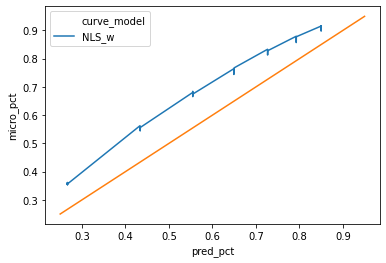

In [271]:
sns.lineplot(x='pred_pct', y='micro_pct', data=data[data['curve_model'] == 'NLS_w'], hue='curve_model')
plt.plot([i for i in np.arange(.25, 1, .1)], [i for i in np.arange(.25, 1, .1)])

In [272]:
data[(data['curve_model'] == 'NLS_w') & (data['run'] == 3)][['pred_pct', 'micro_pct']]

,pred_pct,micro_pct
42,0.266737,0.361807
44,0.433914,0.553672
46,0.554952,0.680572
48,0.649586,0.759513
50,0.727215,0.825904
52,0.793079,0.873823
54,0.850290,0.909775
